# What is Regression Dilution?

The motivating example to explain regression dilution is on the attempt to do simple linear regression assuming a linear model between two variables $x^*$ and $y^*$ with residual as the intrinsic scatter $\varepsilon$. However the data collected from these two variables $(x, y)$ include error which we classically assum it's Gaussian noise:

$
\begin{align}
    x_i &= x_i^* + \epsilon_{x,i}\\
    y_i &= y_i^* + \epsilon_{y,i}
\end{align}
$

## Exact Solution without Measurement Error &mdash; Ordinary Least Squares

Without error the model has simple solutions to estimate its slope $\hat\theta_1$ where this particular estimator minimize the sum of squared y-residuals $\left(\sum_{i=1}^N{(y^* - \theta_1 x^* - \theta_0)^2}\right)$ (the usual objective of ordinary least squares):

$
\begin{align}
    y_i^* &= \theta_1 x_i^* + \theta_0 + \varepsilon & \forall i \in \{1,2,\ldots,N\}\\
    \hat\theta_1 &= \frac{\text{Cov}(x^*, y^*)}{\text{Var}(x^*)}
\end{align}
$

In fact, the RHS can be expressed by the correlation $r_{xy}$ by its definition:

$
\begin{align}
    \hat\theta_1 &= r_{xy}\frac{\text{SD}(y^*)}{\text{SD}(x^*)}\\
    r_{xy} &= \hat\theta_1\frac{\text{SD}(x^*)}{\text{SD}(y^*)}
\end{align}
$

Here we see indeed for OLS on data without measurement error, solving for slope equivalently solves for correlation and vice versa. These are dual problems.

## With Measurement Error, Ordinary Least Squares is Biased

With measurement error (assume $\varepsilon$ has scatter $\sigma$, $\epsilon_x$ has scatter $\sigma_x$, and $\epsilon_y$ has scatter $\sigma_y$ for all data points for simplicity) and if we apply the same procedure as OLS,

$
\begin{align}
    \hat\theta_1 &= \frac{\text{Cov}(x, y)}{\text{Var}(x)} \\
    &= \frac{\text{Cov}(x^* + \epsilon_x, y + \epsilon_y)}{\text{Var}(x^* + \epsilon_x)}\\
    &= \frac{\text{Cov}(x^*, y^*) + \sigma_{xy}}{\text{Var}(x^*) + \sigma_x^2}\\
    &= \frac{\text{Cov}(x^*, y^*)}{\text{Var}(x^*) + \sigma_x^2}
\end{align}
$

Where $\sigma_{xy}$ is the covariance between $\epsilon_x$ and $\epsilon_y$. Let's take the case where $\epsilon_x$ and $\epsilon_y$ are independent therefore the last line above, we set $\sigma_{xy}=0$.

We can see from the denominator the extra additive term of $\sigma_x$. This defines the regression dilution in OLS where the scatter in x-error causes underestimation of the slope. The same effect applies to correlation as we can see that,

$
\begin{align}
    r_{xy} &\equiv \frac{\text{Cov}(x^* + \epsilon_x, y^* + \epsilon_y)}{\sqrt{\text{Var}(x^* + \epsilon_x)\text{Var}(y^* + \epsilon_y)}} \\
           &= \frac{\text{Cov}(x^*, y^*) + \sigma_{xy}}{\sqrt{\big[\text{Var}(x^*) + \sigma_x^2\big] \big[\text{Var}(y^*) + \sigma_y^2\big]}} \\
           &= \frac{\text{Cov}(x^*, y^*)}{\sqrt{\big[\text{Var}(x^*) + \sigma_x^2\big] \big[\text{Var}(y^*) + \sigma_y^2\big]}} \\
           &= \frac{\hat\theta_1}{\text{Var}(y^*) + \sigma_y^2}
\end{align}
$

Correlation has the additional affect that not only x-error causes underestimation but also y-error.

## Correcting Regression Dilution in Correlation

There are many methods to correct for regresson dilution. One method used here, relies on the reliability metric $r_{xx}$ and $r_{yy}$ defined as

$
\begin{align}
    r_{zz} = \frac{\text{Var}(z) - \text{Var}(\epsilon_z)}{\text{Var}(z)}
\end{align}
$

The correction is then,

$
\begin{align}
    r_{xy}' = \frac{r_{xy}}{\sqrt{r_{xx}r_{yy}}}
\end{align}
$

# Simulating Regression Dilution

In [45]:
import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import curve_fit, minimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(91320)
sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

## Population Definition

### Bivariate Normal

In [2]:
size = 1000000
rho_xy = 0.25
sigma_x = 1
sigma_y = 1
cov_xy = rho_xy * (sigma_x * sigma_y)
cov = np.array([[sigma_x**2,    cov_xy], 
                [ cov_xy,   sigma_y**2]])
m = rho_xy * sigma_y / sigma_x
b = 0

population_dist = stats.multivariate_normal(cov=cov)
population_sample = population_dist.rvs(size)
x, y = population_sample[:, 0], population_sample[:, 1]
r_xy = stats.pearsonr(x, y)[0]
m_best =  r_xy * np.std(y) / np.std(x)
b_best =  np.mean(y) - m_best*np.mean(x)

print("Population Correlation:", r_xy)

Population Correlation: 0.24974542732423816


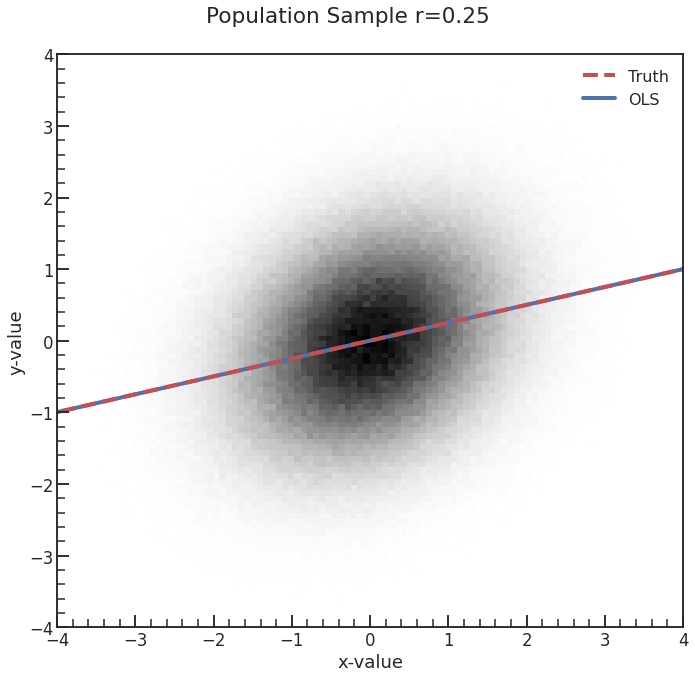

In [3]:
def f(x, m, b):
    return m*x + b

fig = plt.figure(figsize=(10, 10))
plt.hist2d(x, y, bins=100, range=[[-4, 4], [-4, 4]], cmap="gray_r");

xrange = np.linspace(-6, 6, 100)
plt.plot(xrange, f(xrange, m_best, b_best), 'r--', label="Truth")


popt, _ = curve_fit(f, x, y)
plt.plot(xrange, f(xrange, *popt), label="OLS", zorder=1)

fig.suptitle("Population Sample r=0.25")
plt.xlabel("x-value")
plt.ylabel("y-value")
plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figures/bivariate.png")

## Measurement Sample

Each measurement sample will be measured with error of constant variance. 

* The first sample will have equal variance on x and y error. 
* The second sample will have x error be 5 times greater than y error. 
* The third will have x error be 10 times greater than y error.

In [4]:
data_size = 100
data_idx = np.random.choice(range(size), size=data_size, replace=False)
xdata_true = x[data_idx]
ydata_true = y[data_idx]

sigma_x = np.ones(data_size) * 0.2
sigma_y = np.ones(data_size) * 0.2
xerr = stats.norm(loc=0, scale=sigma_x).rvs(data_size)
yerr = stats.norm(loc=0, scale=sigma_y).rvs(data_size)

### Measurement Sample 1

Both x and y has single value errors with error ratio of 1.

,x,xerr,y,yerr
59,-2.534034,0.2,-1.821711,0.2
32,-2.355149,0.2,-0.434700,0.2
99,-1.987053,0.2,-0.605637,0.2
23,-1.888024,0.2,-0.072284,0.2
17,-1.740163,0.2,0.200211,0.2


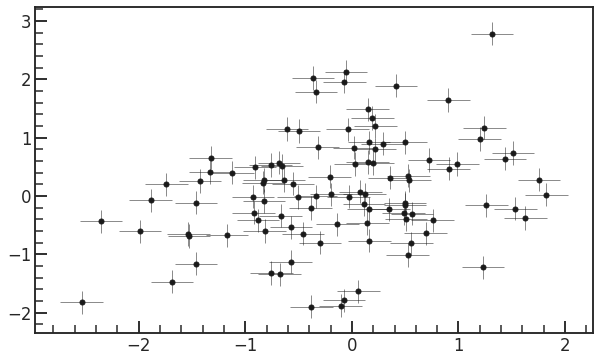

In [5]:
xdata = xdata_true + xerr*1
ydata = ydata_true + yerr*1

df1 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df1.x, df1.y, yerr=df1.yerr, xerr=df1.xerr, c='k', fmt='ko', lw=0.5, ms=5)
df1.head()

### Measurement Sample 2

Both x and y has single value errors with error ratio x of y being 5

,x,xerr,y,yerr
32,-3.325299,1.0,-0.434700,0.2
70,-2.733440,1.0,0.399521,0.2
59,-2.607203,1.0,-1.821711,0.2
17,-2.348447,1.0,0.200211,0.2
93,-2.171553,1.0,0.255343,0.2


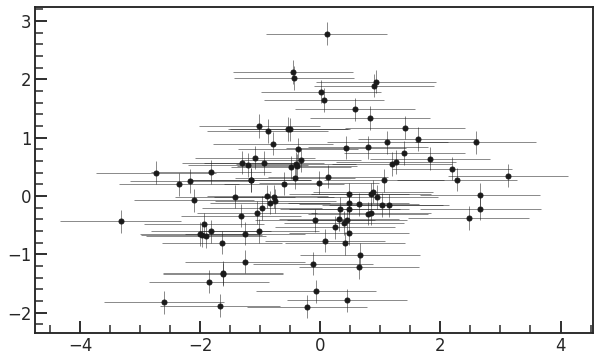

In [6]:
xdata = xdata_true + xerr*5
ydata = ydata_true + yerr*1

df2 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*5,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df2.x, df2.y, yerr=df2.yerr, xerr=df2.xerr, c='k', fmt='ko', lw=0.5, ms=5)
df2.head()

### Measurement Sample 3

Both x and y has errors of variance uniformly assigned. The error ratio is about 5

,x,xerr,y,yerr
70,-4.746761,2.0,0.399521,0.2
32,-4.537986,2.0,-0.434700,0.2
69,-4.187530,2.0,-0.484815,0.2
6,-3.635816,2.0,-1.879427,0.2
86,-3.315032,2.0,-0.801786,0.2


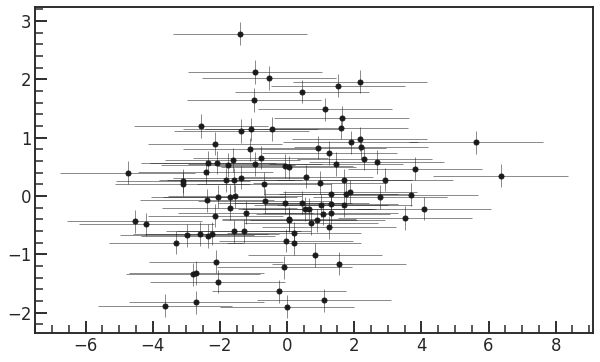

In [7]:
xdata = xdata_true + xerr*10
ydata = ydata_true + yerr*1

df3 = pd.DataFrame(
    {
        "x": xdata,
        "xerr": sigma_x*10,
        "y": ydata,
        "yerr": sigma_y,
    }
).sort_values('x')

plt.errorbar(df3.x, df3.y, yerr=df3.yerr, xerr=df3.xerr, c='k', fmt='ko', lw=0.5, ms=5)
df3.head()

## Regression Dilution in OLS

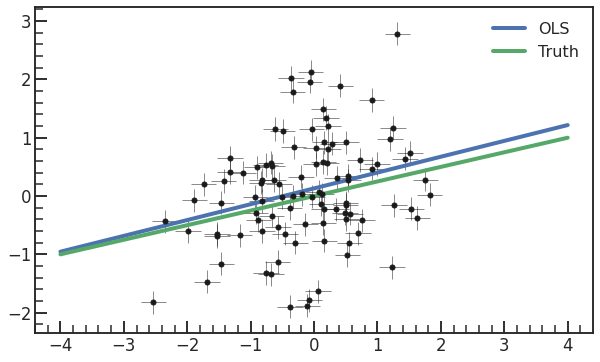

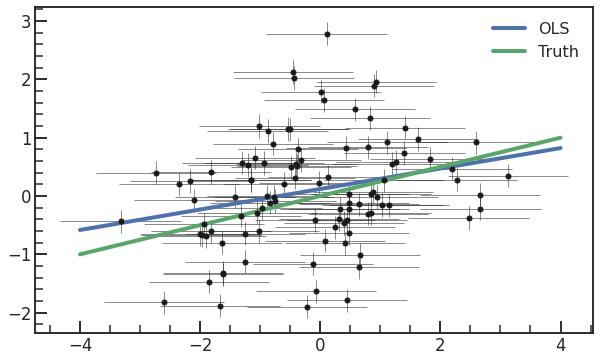

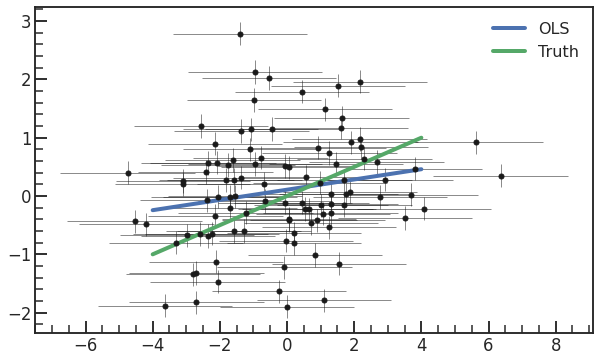

In [8]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

def get_intercept_parameter(x, y, slope):
    """Return the mean of the OLS intercept parameter"""
    corr = stats.pearsonr(x, y)[0]
    intercept = np.mean(y) - slope*np.mean(x)
    
    return intercept

slope, slope_var = get_slope_parameter(df1.x, df1.y)
intercept = get_intercept_parameter(df1.x, df1.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df1.x, df1.y, yerr=df1.yerr, xerr=df1.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")

plt.legend()

slope, slope_var = get_slope_parameter(df2.x, df2.y)
intercept = get_intercept_parameter(df2.x, df2.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df2.x, df2.y, yerr=df2.yerr, xerr=df2.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")
plt.legend()

slope, slope_var = get_slope_parameter(df3.x, df3.y)
intercept = get_intercept_parameter(df3.x, df3.y, slope)
xrange = np.linspace(-4, 4, 100)
plt.figure()
plt.errorbar(df3.x, df3.y, yerr=df3.yerr, xerr=df3.xerr, c='k', fmt='ko', lw=0.5, ms=5)
plt.plot(xrange, f(xrange, slope, intercept), label="OLS")
plt.plot(xrange, f(xrange, m, b), c='g', label="Truth")
plt.legend()

## Regression Dilution in Simulation

In [9]:
def simulate(x, y, xerr, yerr, repetition=1000):
    
    corrs = []
    slopes = []
    intercepts = []
    for i in range(repetition):
        xdist = stats.norm(loc=x, scale=xerr)
        ydist = stats.norm(loc=y, scale=yerr)
        
        xsample = xdist.rvs()
        ysample = ydist.rvs()
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
    
    
    
    return pd.DataFrame({"corr": corrs, "slope": slopes, "intercept": intercept})


result_df1 = simulate(df1.x, df1.y, df1.xerr, df1.yerr)
result_df2 = simulate(df2.x, df2.y, df2.xerr, df2.yerr)
result_df3 = simulate(df3.x, df3.y, df3.xerr, df3.yerr)

In [10]:
# def simulate(x, y, xerr, yerr, sample_size=10000):
    
#     xsample = []
#     ysample = []
#     for i in range(len(x)):
#         xdist = stats.norm(loc=x[i], scale=xerr[i])
#         ydist = stats.norm(loc=y[i], scale=yerr[i])
        
#         xsample.extend(xdist.rvs(size=sample_size))
#         ysample.extend(ydist.rvs(size=sample_size))
    
#     df = pd.DataFrame({
#         "x": xsample,
#         "y": ysample
#     })
    
#     return df


# s1_df = simulate(df1.x, df1.y, df1.xerr, df1.yerr)
# s2_df = simulate(df2.x, df2.y, df2.xerr, df2.yerr)
# s3_df = simulate(df3.x, df3.y, df3.xerr, df3.yerr)

# small_s1_df = simulate(df1.x, df1.y, df1.xerr, df1.yerr, sample_size=50)
# small_s2_df = simulate(df2.x, df2.y, df2.xerr, df2.yerr, sample_size=50)
# small_s3_df = simulate(df3.x, df3.y, df3.xerr, df3.yerr, sample_size=50)

## Regression Dilution in LINMIX

In [11]:
from linmix import linmix

lm1 = linmix.LinMix(df1.x, df1.y, df1.xerr, df1.yerr, K=3)
lm1.run_mcmc(silent=True, miniter=1000, maxiter=1000)

lm2 = linmix.LinMix(df2.x, df2.y, df2.xerr, df2.yerr, K=3)
lm2.run_mcmc(silent=True, miniter=1000, maxiter=1000)

lm3 = linmix.LinMix(df3.x, df3.y, df3.xerr, df3.yerr, K=3)
lm3.run_mcmc(silent=True, miniter=1000, maxiter=1000)

,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.271,0.271,0.886,1,0.978,1,-0.021,3,2
OLS (corrected),0.285,0.284,0.886,2,0.978,2,-0.034,5,5
Bootstrap,0.259,0.258,0.887,4,0.981,4,-0.008,1,1
Bootstrap (corrected),0.272,0.271,0.887,5,0.982,5,-0.021,2,3
LINMIX,0.284,0.283,0.886,3,0.979,3,-0.033,4,4


,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.176,0.252,0.891,1,0.979,1,-0.002,1,1
OLS (corrected),0.894,0.395,0.891,2,1.170,5,-0.145,4,5
Bootstrap,0.113,0.198,0.896,3,0.981,2,0.052,2,2
Bootstrap (corrected),0.702,0.311,0.896,4,1.072,4,-0.061,3,4
LINMIX,0.458,0.940,0.966,5,1.004,3,-0.690,5,3


,slope,corr,rmse,rmse rank,trmse,trmse rank,corr_residual,corr rank,slope rank
method,,,,,,,,,
OLS,0.088,0.204,0.901,1,0.988,1,0.046,1,1
OLS (corrected),3.112,0.593,0.901,2,3.027,5,-0.343,4,5
Bootstrap,0.048,0.149,0.905,3,0.995,2,0.101,2,2
Bootstrap (corrected),2.281,0.434,0.905,4,2.255,4,-0.184,3,4
LINMIX,0.551,2.969,1.339,5,1.035,3,-2.719,5,3


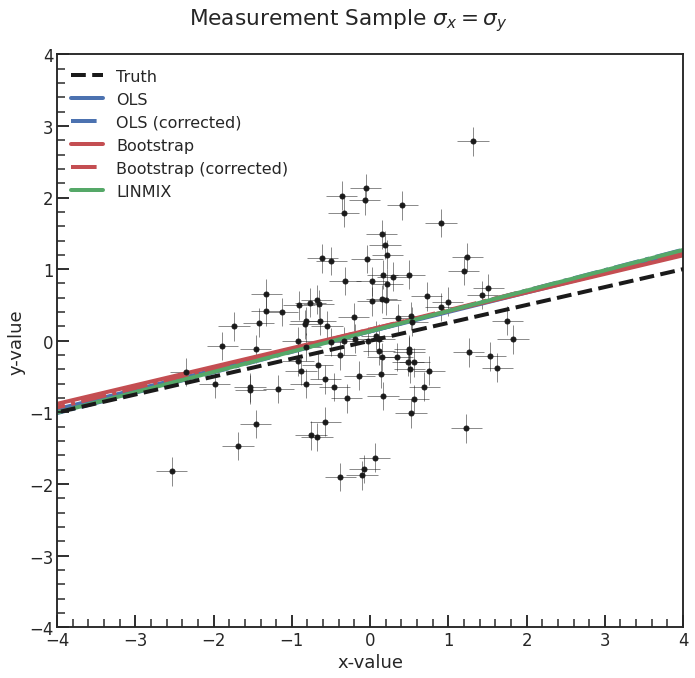

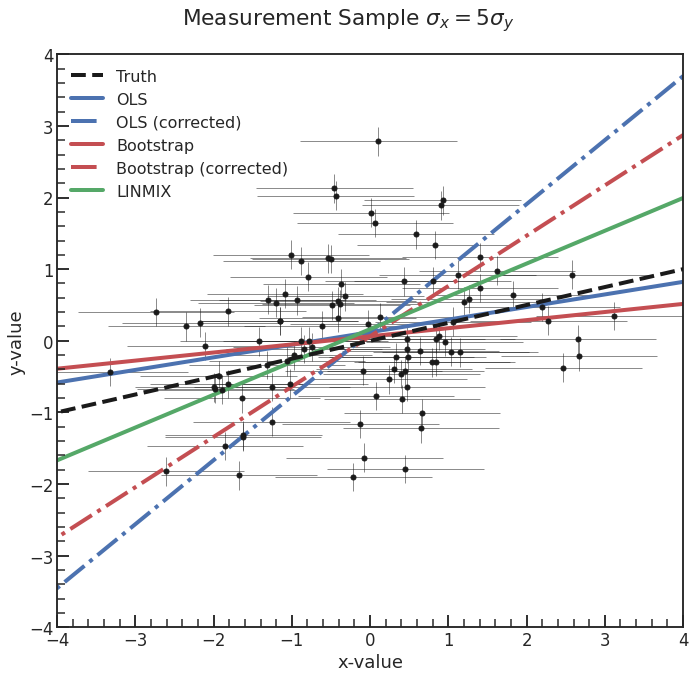

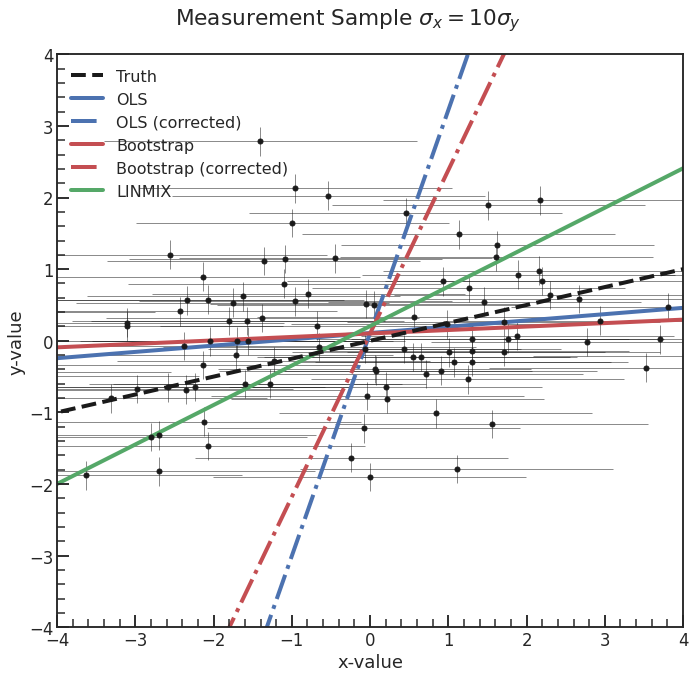

In [12]:
def rmse(y, ypred):
    return np.sqrt(np.mean((y - ypred)**2))

def slope_to_corr(x, y, slope):
    """ THIS IS WRONG """
    return slope * (np.var(x) / np.var(y))

def corr_to_slope(corr, x, xerr, y, yerr):
    return corr * np.std(y) / np.std(x)

def get_reliability(x, xerr):
    return (np.var(x) - np.mean(xerr**2)) / np.var(x)
    

def summary_plot(df, result_df, lm, title=""):
    fig, ax1 = plt.subplots(figsize=(10, 10))
    fig.suptitle(title)
    summary = []
    
    # Truth
    xrange = np.linspace(-6, 6, 100)
    ax1.plot(xrange, f(xrange, m, b), 'k--', label="Truth", zorder=100)

    # Ordinary Least Squares
    slope, slope_var = get_slope_parameter(df.x, df.y)
    corr = stats.pearsonr(df.x, df.y)[0]
    intercept = get_intercept_parameter(df.x, df.y, slope)

    ax1.errorbar(df.x, df.y, yerr=df.yerr, xerr=df.xerr, fmt='ko', lw=0.5, ms=5)
    ax1.plot(xrange, f(xrange, slope, intercept), 'b', label="OLS")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

    summary.append({
        "method": "OLS",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })
    
    rxx = get_reliability(df.x, df.xerr)
    ryy = get_reliability(df.y, df.yerr)
    corr = corr / np.sqrt(rxx*ryy)
    slope = corr_to_slope(corr, df.x, df.xerr, df.y, df.yerr)
    
    ax1.plot(xrange, f(xrange, slope, intercept), 'b-.', label="OLS (corrected)")
    summary.append({
        "method": "OLS (corrected)",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })


    # Bootstrap
    slope = result_df["slope"].mean()
    corr = result_df["corr"].mean()
    intercept = result_df["intercept"].mean()
    ax1.plot(xrange, f(xrange, slope, intercept), 'r', label="Bootstrap")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)
    
    summary.append({
        "method": "Bootstrap",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })
    
    rxx = get_reliability(df.x, df.xerr)
    ryy = get_reliability(df.y, df.yerr)
    corr = corr / np.sqrt(rxx*ryy)
    slope = corr_to_slope(corr, df.x, df.xerr, df.y, df.yerr)
    
    ax1.plot(xrange, f(xrange, slope, intercept), 'r-.', label="Bootstrap (corrected)")
    summary.append({
        "method": "Bootstrap (corrected)",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })

    # LINMIX
    slope, intercept = np.mean(lm.chain['beta']), np.mean(lm.chain['alpha'])
    corr = slope_to_corr(df.x, df.y, slope)
    ax1.plot(xrange, f(xrange, slope, intercept), 'g', label="LINMIX")
    ypred = slope*df.x + intercept
#     ax2.plot(df.x, df.y - ypred, marker='.', lw=2)

    summary.append({
        "method": "LINMIX",
        "rmse": rmse(df.y, ypred),
        "trmse": rmse(y, slope*x+intercept),
        "slope": slope,
        "corr": corr,
        "corr_residual": rho_xy - corr
    })

    ax1.legend(loc="upper left")
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax1.set_ylabel("y-value")
    ax1.set_xlabel("x-value")
#     ax2.set_ylabel("Residual")
#     ax2.xaxis.tick_top()
    
    summary_df = pd.DataFrame(summary)
    summary_df["rmse rank"] = stats.rankdata(summary_df.rmse, method="ordinal")
    summary_df["trmse rank"] = stats.rankdata(summary_df.trmse, method="ordinal")
    summary_df["corr rank"] = stats.rankdata(np.abs(summary_df["corr_residual"]), method="ordinal")
    summary_df["slope rank"] = stats.rankdata(np.abs(summary_df["slope"] - m), method="ordinal")
    summary_df= summary_df.set_index("method")[["slope", "corr", "rmse", "rmse rank", "trmse", "trmse rank", "corr_residual", "corr rank", "slope rank"]]

    display(summary_df.round(3))
    # plt_table = pd.plotting.table(ax2, summary_df.round(3))
    # plt_table.scale(0.6, 3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f'figures/{title.replace(" ", "_").lower()}.png'
    plt.savefig(filename)
    return summary_df


summary_plot(df1, result_df1, lm1, title="Measurement Sample $\sigma_x=\sigma_y$");
summary_plot(df2, result_df2, lm2, title="Measurement Sample $\sigma_x=5\sigma_y$");
summary_plot(df3, result_df3, lm3, title="Measurement Sample $\sigma_x=10\sigma_y$");

[4.86262257 1.7219579  0.        ] True Optimization terminated successfully.


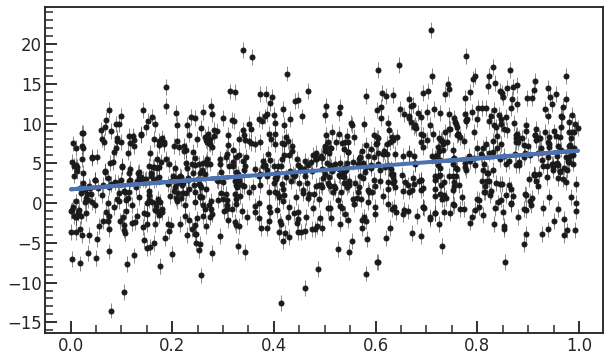

In [146]:
def chi2_loss(params, x, y, xerr=0, yerr=0):
    slope, intercept, scatter = params
    
    ypred = slope * x + intercept
    denom = np.sqrt(xerr**2 + yerr**2 + scatter**2)
    chi2 = np.mean((y - ypred)**2 / denom)
    return chi2

def l2_loss(params, x, y):
    slope, intercept, scatter = params
    
    ypred = slope * x + intercept
    loss = np.mean((y - ypred)**2)
    return loss

xrange = np.random.uniform(0, 1, 1000)
yrange = xrange * 5 + 2 + stats.norm(scale=5).rvs(len(xrange))
res = minimize(chi2_loss, x0=(1, 0, 0), args=(xrange, yrange, 1, 1))


def _plot():
    slope, intercept, scatter = res.x
    print(res.x, res.success, res.message)
    plt.errorbar(xrange, yrange, yerr=1, fmt='ko', lw=0.5, ms=5)
    plt.plot(xrange, slope*xrange + intercept, zorder=100)
    
_plot()

In [162]:
def simulate_all_fittings(x, y, sample_size=100, reps=5, linmix_kwargs=dict(miniter=2500, maxiter=2500)):
    data_size = sample_size
    size = len(x)
    
    results = {
        "OLS": [],
        "OLS_c": [],
        "Bootstrap": [],
        "Bootstrap_c": [],
        "LINMIX": [],
        "Chi2": []
    }
    slope_results {k: [] for k in results}
    chi2_success = []
    
    for i in range(reps):
        data_idx = np.random.choice(range(size), size=data_size, replace=False)
        xdata_true = x[data_idx]
        ydata_true = y[data_idx]

        sigma_x = np.ones(data_size)
        sigma_y = np.ones(data_size)
        xerr = stats.norm(loc=0, scale=sigma_x).rvs(data_size)
        yerr = stats.norm(loc=0, scale=sigma_y).rvs(data_size)

        xdata = xdata_true + xerr
        ydata = ydata_true + yerr

        df = pd.DataFrame(
            {
                "x": xdata,
                "xerr": sigma_x,
                "y": ydata,
                "yerr": sigma_y,
            }
        ).sort_values('x')

        # Ordinary Least Squares
        slope, slope_var = get_slope_parameter(df.x, df.y)
        corr = stats.pearsonr(df.x, df.y)[0]
        intercept = get_intercept_parameter(df.x, df.y, slope)
        ypred = slope*df.x + intercept
        results["OLS"].append(corr)
        slope_results["OLS"].append(slope)
        
        rxx = get_reliability(df.x, df.xerr)
        ryy = get_reliability(df.y, df.yerr)
        corr = corr / np.sqrt(rxx*ryy)
        slope = corr_to_slope(corr, df.x, df.xerr, df.y, df.yerr)
        results["OLS_c"].append(corr)
        slope_results["OLS_c"].append(slope)
        
        # Chi-2 with y-scatter, x-scatter, and residual
        res = minimize(chi2_loss, x0=(1, 0, 1), args=(df1.x, df.y, df.xerr, df.yerr))
        print(res.success)
        slope, intercept, _ = res.x
        corr = slope_to_corr(df.x, df.y, slope)
        results["Chi2"].append(corr)
        slope_results["Chi2"].append(slope)
        
        # BOOTSTRAP
        bootstrap_df = simulate(df.x, df.y, df.xerr, df.yerr)
        slope = bootstrap_df["slope"].mean()
        corr = bootstrap_df["corr"].mean()
        intercept = bootstrap_df["intercept"].mean()
        results["Bootstrap"].append(corr)
        slope_results["Bootstrap"].append(slope)
        
        rxx = get_reliability(df.x, df.xerr)
        ryy = get_reliability(df.y, df.yerr)
        corr = corr / np.sqrt(rxx*ryy)
        slope = corr_to_slope(corr, df.x, df.xerr, df.y, df.yerr)
        results["Bootstrap_c"].append(corr)
        slope_results["Bootstrap_c"].append(slope)
        
        # LINMIX
        lm = linmix.LinMix(df.x, df.y, df.xerr, df.yerr, K=3)
        lm.run_mcmc(silent=True, **linmix_kwargs)
        
        slope, intercept = np.mean(lm.chain['beta']), np.mean(lm.chain['alpha'])
        corr = slope_to_corr(df.x, df.y, slope)
        results["LINMIX"].append(corr)
        slope_results["LINMIX"].append(slope)
        
        print(f"{i}/{reps}", end="\r")
        
    corr_df = pd.DataFrame(results)
    corr_df.to_csv("results/regression-dilution-model-comparison.csv", index=False)
    
    slope_df = pd.DataFrame(slope_results)
    slope_df.to_csv("results/regression-dilution-model-comparison_slope.csv", index=False)

# simulate_all_fittings(x, y, reps=250)
_df = pd.read_csv("results/regression-dilution-model-comparison.csv").set_index("Unnamed: 0")

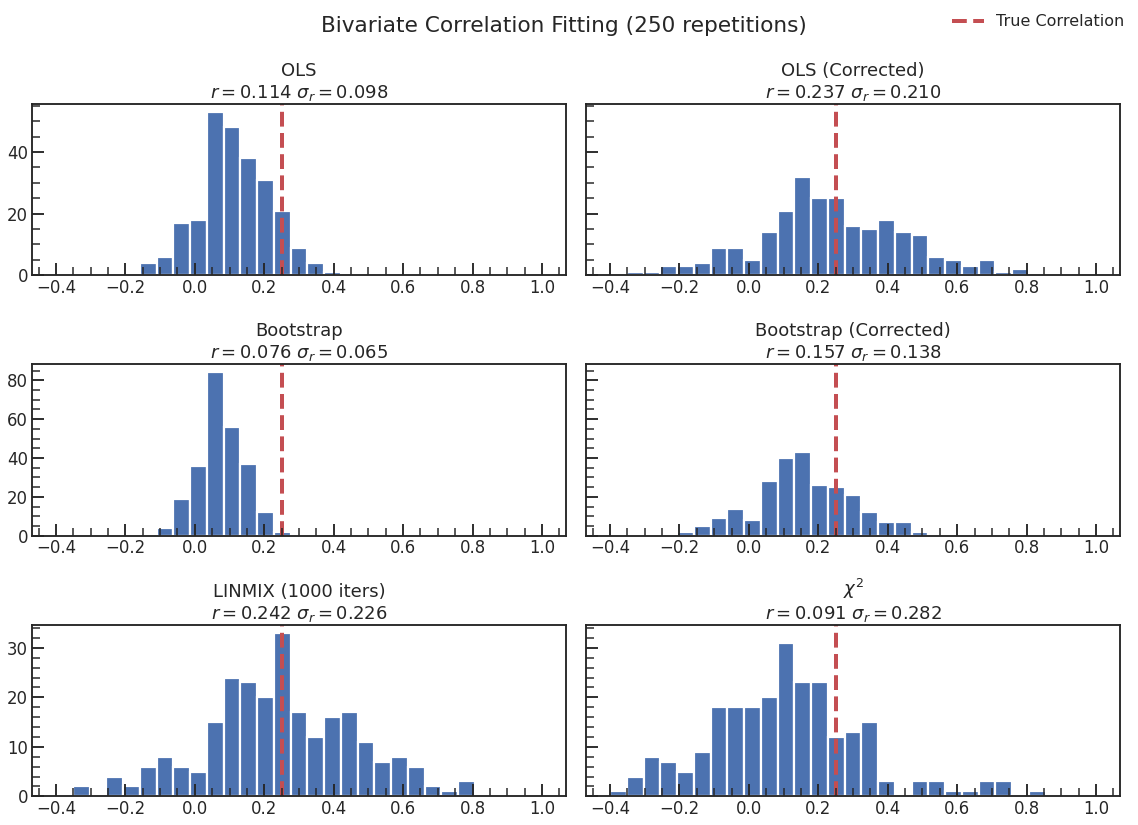

In [160]:
bins = np.linspace(-0.4, 1, 30)
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows), sharey="row")
plt.subplots_adjust(wspace=0)

for i, col in enumerate(_df.columns):
    corr = _df.T.loc[col]
    ax = axs[i//ncols, i%ncols]
    ax.hist(corr, bins)
    col_title = col.replace("_c", " (Corrected)").replace("LINMIX", "LINMIX (1000 iters)").replace("Chi2", "$\chi^2$")
    ax.set_title(f"{col_title}\n$r={corr.mean():.3f}$ $\sigma_r={corr.std():.3f}$")
    ax.axvline(rho_xy, c='r', linestyle="--", label="True Correlation")
    
handles, labels = ax.get_legend_handles_labels()
fig.suptitle(f"Bivariate Correlation Fitting ({len(_df)} repetitions)")
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figures/regression-dilution-model-comparison.png")